# Probabilistic Programming 2: Mixture modeling

## Monte Carlo sampling

In this notebook, we are exploring a more complex problem set, namely mixture modeling. It will show you how to extend the sampling procedure to the multivariate case.

### Preliminaries

- Goal 
  - Write a Monte Carlo sampling procedure for a 2-dimensional mixture model.
- Materials        
  - Mandatory
    - These lecture notes.
  - Optional
    - [Tutorials using Turing.jl](https://turing.ml/dev/tutorials/0-introduction/)
    - [Probabilistic Programming notebook](https://github.com/bertdv/BMLIP/tree/master/lessons/notebooks/probprog/Probabilistic-Programming.ipynb)
    - [Cheatsheets: how Julia differs from Matlab / Python](https://docs.julialang.org/en/v1/manual/noteworthy-differences/index.html)

In [ ]:
# Package managing
using Pkg
Pkg.activate("workspace")
Pkg.instantiate()

include("../scripts/pp-2.jl")

using Logging; disable_logging(LogLevel(0))
using Distributions
using LaTeXStrings
using MCMCChains
using Turing; Turing.setadbackend(:forward_diff)
using StatsPlots
using Plots; 
pyplot();

## Data generation

We generate samples from three 2-dimensional Gaussian distributions and mix these. These Gaussians are:

$$
\begin{align*}
\mathcal{N}_1 \Big(\begin{bmatrix}-2 \\ -2 \end{bmatrix}, \begin{bmatrix}1 & 0 \\0 & 3 \end{bmatrix}\Big) \, , \quad
\mathcal{N}_2 \Big(\begin{bmatrix}+2 \\ +2 \end{bmatrix}, \begin{bmatrix}3 & 0 \\0 & 1 \end{bmatrix}\Big) \, , \quad
\mathcal{N}_3 \Big(\begin{bmatrix}-2 \\ +2 \end{bmatrix}, \begin{bmatrix}1 & 0 \\0 & 1 \end{bmatrix}\Big) \, .
\end{align*}
$$

We draw $N_1$, $N_2$ and $N_3$ samples from each, respectively.

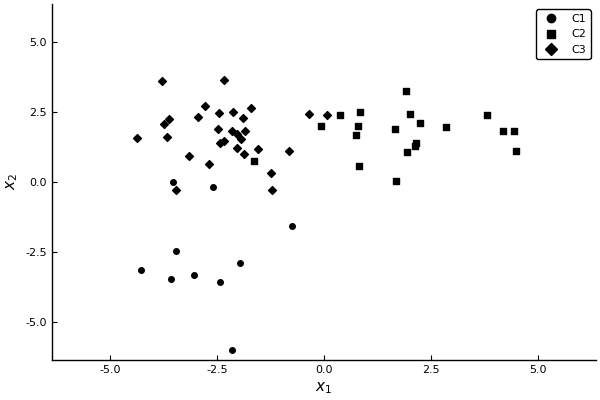

In [2]:
# Sample size
N = [10, 20, 30]

# Parameters for each cluster
μ1 = [-2. -2.]
Σ1 = [1.0 0.0; 0.0 3.0]
μ2 = [+2. +2.]
Σ2 = [3.0 0.0; 0.0 1.0]
μ3 = [-2. +2.]
Σ3 = [1.0 0.0; 0.0 1.0]

function generate_data(means::Array{Float64,2}, 
                       covariances::Array{Float64,3}; 
                       num_samples::Array{Int64,1}=[10])
    "Generate data from a 2-dimensional mixture model"
    
    # Extract number of components
    K = length(num_samples)
    
    # Extract dimensionality
    D = size(covariances)[1]
    
    # Preallocate vectors
    X = zeros(sum(num_samples), D)
    C = zeros(sum(num_samples),)
    
    # Create sample index
    ix = cat(0, cumsum(num_samples), dims=1)
    
    for k = 1:K
        
        # Current indices
        ix_k = (ix[k]+1:ix[k+1])
    
        # Sample from cluster component
        X[ix_k, :] = rand(MvNormal(means[k,:], covariances[:,:,k]), num_samples[k])'
        
        # Store cluster origin
        C[ix_k,] = k*ones(num_samples[k])
        
    end
    
    return X, C
end

# Generate data
observations, cluster = generate_data(cat(μ1, μ2, μ3, dims=1), cat(Σ1, Σ2, Σ3, dims=3), num_samples=N)

# Visualization
scatter(observations[cluster.==1, 1], observations[cluster.== 1, 2], color="black", marker=:circle, label="C1")
scatter!(observations[cluster.==2, 1], observations[cluster.== 2, 2], color="black", marker=:square, label="C2")
scatter!(observations[cluster.==3, 1], observations[cluster.== 3, 2], 
         marker=:diamond,
         color="black",
         label="C3", 
         xlabel=L"$x_1$", 
         ylabel=L"$x_2$", 
         xlim=[-6, 6], 
         ylim=[-6, 6], 
         size=(600,400),
         grid=false)

## Model specification

Let's quickly recap the $K$-component Gaussian mixture model. 

We have a data set of $X$ of $N$ samples by $D$ features. Each component is a Gaussian distribution, $ p_k(x \mid \mu_k, \Sigma_k) \triangleq \mathcal{N}(x \mid \mu_k, \Sigma_k)$. In total, we model $N$ samples:

$$ p(X \mid z, \mu, \Sigma) = \sum_{i=1}^{N} \sum_{k=1}^{K} p_k(x_i \mid \mu_k, \Sigma_k)^{z_i=k} \, .$$

<!-- Note that we summarize parameters as follows: $\phi = (\phi_1, \dots, \phi_K), \mu = (\mu_1, \dots, \mu_K), \Sigma = (\Sigma_1, \dots, \Sigma_K)$.  -->
The variable $z_i$ is the assignment of sample $i$ to class $k$. The probability $p(z_{i} = k)$ is also called the _responsibility_ of component $k$ for the $i$-th sample. All $z_i$ follow a Categorical distribution with mixture weights as parameters:

$$ p(z_i) \sim \text{Cat}(\phi) \, ,$$

Being Bayesians, we put priors on all unknown parameters ($\phi, \mu, \Sigma$):

$$ \begin{align}
p(\phi) \sim&\ \text{Dir}(a_0) \\
p(\mu) \sim&\ \mathcal{N}(m_0, l_0^{-1}\Sigma) \\
p(\Sigma) \sim&\ \mathcal{W}(W_0, v_0) \end{align} \, .$$

The distribution for the mixture weights, $p(\phi)$, follows a Dirichlet distribution because it is a vector that should sum to one. The component parameter priors are a Wishart distribution for the covariance matrix and a Gaussian distribution for the mean, conditioned on the sampled covariance matrix. Together, these two priors form a [Normal-Inverse-Wishart distribution](https://en.wikipedia.org/wiki/Normal-inverse-Wishart_distribution), $p(\mu, \Sigma)$, which is the conjugate prior for the Gaussian components. The full joint distribution is therefore:

$$ \begin{align} p(X, z, \phi, \mu, \Sigma) =&\ p(X \mid z, \phi, \mu, \Sigma)\ p(z \mid \phi)\ p(\mu, \Sigma)\ p(\phi) \\
=&\ \sum_{i=1}^{N} \sum_{k=1}^{K} \mathcal{N}(x_i \mid \mu_k, \Sigma_k)^{z_i=k}\ \text{Cat}(z_i=k \mid \phi_k)\ \mathcal{NIW}(\mu_k, \Sigma_k \mid m_{0k}, l_{0k}, W_{0k}, v_{0k})\ \text{Dir}(\phi_k \mid a_{0k}) \end{align}$$

We are interested in the posterior distribution over $z$, which assigns the current samples to clusters via $\arg \max_{k} p(z_i = k)$. For example, if the posterior distribution for $z_i$ is $[0.32\ 0.21\ 0.47]$, then the $\arg \max_k$ is 3 and we say that $x_i$ belongs to component 3. We are also interested in the posterior distributions for the component parameters, because these allow us to assign future samples to the current clusters. The posterior for $z, \phi, \mu, \Sigma$ has the form:

$$p(z, \phi, \mu, \Sigma \mid X) = \frac{p(X, z, \phi, \mu, \Sigma)}{\int p(X, z, \phi, \mu, \Sigma)\ \mathrm{d}X} \, .$$

We cannot evaluate the integral in the denominator, but because it only serves as a normalization factor we ignore it for now. Note that the numerator is the joint distribution. Unfortunately, it doesn't simplify to a known form. However, in mixture models, it is usually possible to perform a conditional factorization into the two distributions: if we fix the parameters $\phi, \mu, \Sigma$ to certain values, we obtain the factor:

$$p(z_i \mid X, \phi, \mu, \Sigma) = \sum_{i=1}^{N} \sum_{k=1}^{K} \rho_k^{z_i = k} \, ,$$

where $\rho_k = \phi_k \mathcal{N}(x_i \mid \mu_k, \Sigma_k)$ for all $k$. This is a Categorical distribution! The only problem is that $\rho$ is not normalized correctly. But we know that it _should_ be correctly normalized, after division by the denominator $\int p(X, z, \phi, \mu, \Sigma) \ \mathrm{d}X$. We can therefore perform the following re-parameterization:

$$r_k = \frac{\rho_k}{\sum_{k} \rho_k} \, .$$

Now, $r_k$ are valid responsibilities for the assignment variable $z$. In other words, $p(z_i \mid X, \phi, \mu, \Sigma) \sim \text{Cat}(r_k)$. 

If we fix $z_i$ to certain values, it acts as a component selector. Take for instance $z_i = 2$;

$$\begin{align} p(\phi_2, \mu_2, \Sigma_2 \mid x_i, z_i) =&\quad \mathcal{N}(x_i \mid \mu_1, \Sigma_1)^{0} \ 0\ \ \ \mathcal{NIW}(\mu_1, \Sigma_1 \mid m_{01}, l_{01}, W_{01}, v_{01}) \ \text{Dir}(\phi_1 \mid a_{01}) \\
&+ \mathcal{N}(x_i \mid \mu_2, \Sigma_2)^{1} \ \phi_2\ \mathcal{NIW}(\mu_2, \Sigma_2 \mid m_{02}, l_{02}, W_{02}, v_{02}) \ \text{Dir}(\phi_2 \mid a_{02}) \\
&+ \mathcal{N}(x_i \mid \mu_3, \Sigma_3)^{0} \ 0\ \ \ \mathcal{NIW}(\mu_3, \Sigma_3 \mid m_{03}, l_{03}, W_{03}, v_{03}) \ \text{Dir}(\phi_3 \mid a_{03}) \\
=& \ \mathcal{N}(x_i \mid \mu_2, \Sigma_2) \ \phi_2\ \mathcal{NIW}(\mu_2, \Sigma_2 \mid m_{02}, l_{02}, W_{02}, v_{02}) \ \text{Dir}(\phi_2 \mid a_{02})  \end{align} \, .$$

Fixing all $z_i$ produces $p(\phi, \mu, \Sigma \mid X, z)$. This can be further factorized into $p(\phi \mid z) p(\mu, \Sigma \mid X)$:

$$\begin{align} 
p(\phi_k \mid z) =&\ \sum_{i=1}^{N} \text{Cat}(z_i \mid \phi_k)\ \text{Dir}(\phi_k \mid a_{0}) \\ 
p(\mu_k, \Sigma_k \mid X) =&\ \sum_{i=1}^{N} \mathcal{N}(x_i \mid \mu_k, \Sigma_k)\ \mathcal{NIW}(\mu_k, \Sigma_k \mid m_{0k}, l_{0k}, W_{0k}, v_{0k}) 
\end{align}$$

which are Dirichlet and a Normal-Inverse-Wishart distributions. So, to summarize:

1. Fix $\phi, \mu, \Sigma$ and compute $p(z \mid X, \phi, \mu, \Sigma)$
2. Fix $z$ and compute both $p(\phi \mid z)$ and $p(\mu, \Sigma \mid X)$.

You will recognize this as being similar to Expectation-Maximization. The difference lies in that we obtain posterior distributions for $\phi, \mu, \Sigma$ instead of point estimates. 

Since the posterior factorizes into marginal distributions, we can apply Gibbs sampling to obtain estimates of the posterior parameters. 

Let's start simple and slowly increase the complexity of the model.

### Model 1: means only

We will assume K=2 classes, equal class proportions, $\phi = [0.5 \ 0.5]$, and spherical covariance matrices, $\Sigma_k = \mathcal{I}$ for all $k$. Using these assumptions, we estimate the means $\mu$ and compute the posterior of $z$.

In [3]:
@model Gaussian_mixture_model(X, m1, m2) = begin
    "2-dimensional Gaussian mixture model with spherical covariances"
    
    # Data shape
    N, D = size(X)

    # Draw the mean for cluster 1
    μ1 ~ MvNormal(m1, 10*[1. 0.; 0. 1.])
    
    # Draw the mean for cluster 2
    μ2 ~ MvNormal(m2, 10*[1. 0; 0. 1.])
    
    # Concatenate means
    μ = [μ1 μ2]
    
    # Probability of belonging to each cluster
    ϕ = [0.5, 0.5]
    
    # Preallocate assignment vector
    z = Vector{Int}(undef, N)
    
    # Loop over observations
    for i in 1:N
        
        # Draw assignment for i-th sample from a Categorical distribution parameterized by ϕ
        z[i] ~ Categorical(ϕ)
        
        # Data point x[i] follows a normal distribution, with mean indexed by the assignment variable z[i]
        X[i,:] ~ MvNormal(μ[:, z[i]], [1. 0; 0. 1.])
    end
    
    # Return the assignments
    return z
end

# Set priors
m1 = [-2, -2]
m2 = [+2, +2]

# Create an instance of a model, using the observations
model1 = Gaussian_mixture_model(observations, m1, m2);

Well construct a Gibbs sampler, partly sampling the cluster assignment $z$ and partly the means.

In [4]:
# Length of chain
len_chain = 1000

# Construct Gibbs sampler
sampler1 = Gibbs(PG(50, :z), HMC(0.01, 10, :μ1, :μ2))

# Start sampling
chain1 = sample(model1, sampler1, len_chain);

Progress: 100%|█████████████████████████████████████████| Time: 0:09:48


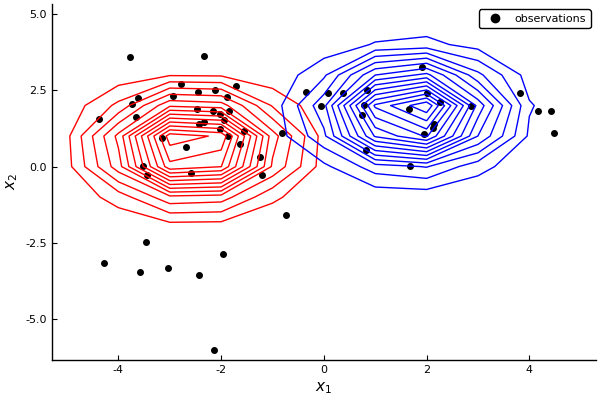

In [5]:
# Extract the means over the MCMC chains
μ1_estimated = mean_chain(chain1, :μ1)
μ2_estimated = mean_chain(chain1, :μ2)

# Plot data and overlay estimated posterior probabilities
plot_clusters(observations, 
              μ=[μ1_estimated, μ2_estimated], 
              x1=range(-5, stop=5), 
              x2=range(-5, stop=5),
              size=(600,400))

Let's take a closer look at the chain. 

In [6]:
describe(chain1[[:μ1, :μ2]])

2-element Array{ChainDataFrame,1}

Summary Statistics
. Omitted printing of 1 columns
│ Row │ parameters │ mean     │ std      │ naive_se  │ mcse      │ ess     │
│     │ Symbol     │ Float64  │ Float64  │ Float64   │ Float64   │ Any     │
├─────┼────────────┼──────────┼──────────┼───────────┼───────────┼─────────┤
│ 1   │ μ1[1]      │ -2.55806 │ 0.348183 │ 0.0110105 │ 0.0672748 │ 6.1808  │
│ 2   │ μ1[2]      │ 0.649474 │ 0.535029 │ 0.0169191 │ 0.118878  │ 7.63263 │
│ 3   │ μ2[1]      │ 1.69761  │ 0.611241 │ 0.0193291 │ 0.141142  │ 6.77938 │
│ 4   │ μ2[2]      │ 1.78943  │ 0.334479 │ 0.0105772 │ 0.0670387 │ 11.3674 │

Quantiles

│ Row │ parameters │ 2.5%      │ 25.0%    │ 50.0%    │ 75.0%    │ 97.5%    │
│     │ Symbol     │ Float64   │ Float64  │ Float64  │ Float64  │ Float64  │
├─────┼────────────┼───────────┼──────────┼──────────┼──────────┼──────────┤
│ 1   │ μ1[1]      │ -3.87281  │ -2.64528 │ -2.51552 │ -2.38011 │ -2.16956 │
│ 2   │ μ1[2]      │ 0.244637  │ 0.430562 │ 0.544694 │ 

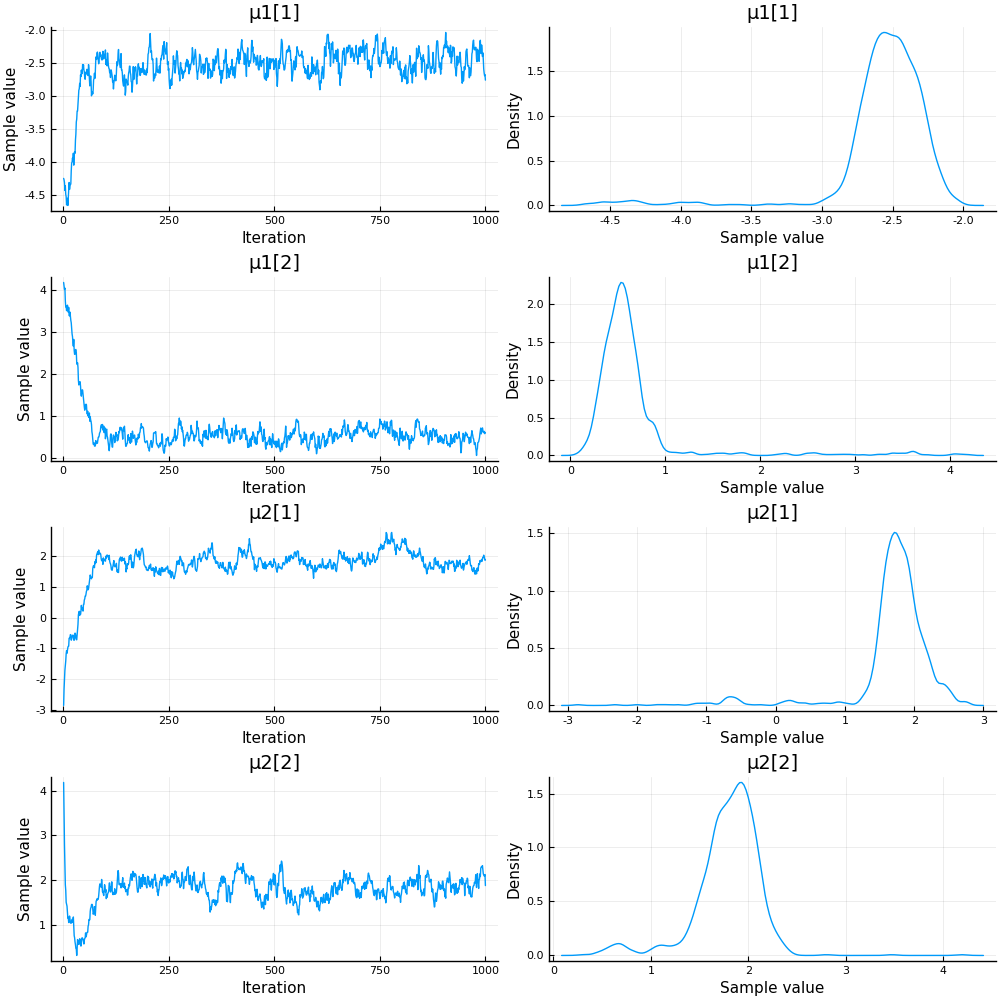

In [7]:
plot(chain1[[:μ1, :μ2]])

### Model 2: means and covariances

We modeled the data with spherical Gaussians. But the data doesn't really look spherical; the cluster plot showed that quite a few samples are not covered by the two Gaussians. This suggests that we should estimate the covariance matrices as well. 

A variance parameter is a strictly positive number and is captured with a Gamma distrbution. A covariance matrix is a positive-definite matrix and can be captured with a Wishart distribution. The [Wishart distribution](https://en.wikipedia.org/wiki/Wishart_distribution) is the natural multivariate extension of the Gamma distribution:

$$ \mathcal{W}_p(C \mid V, n) = \frac{1}{2^{np/2} \ |V|^{n/2} \ \Gamma_p(n/2)} |C|^{(n-p-1)/2} \exp(-\text{tr}(V^{-1}C)/2)$$

where $p$ is the dimensionality of the matrix-variate, $n$ is the degrees of freedom and $V$ is a scale matrix. $\Gamma_p$ is a multivariate gamma function (continuous version of the factorial function).

It is relatively straightforward to add two Wishart priors to the model:

In [8]:
@model Gaussian_mixture_model(X, m1, m2, S1, S2) = begin
    "2-dimensional Gaussian mixture model with free covariances"
    
    # Data shape
    N, D = size(X)
    
    # Draw a covariance matrix for each cluster
    Σ1 ~ InverseWishart(2, S1)
    Σ2 ~ InverseWishart(2, S2)
    
    # Draw means for each cluster
    μ1 ~ MvNormal(m1, Σ1)
    μ2 ~ MvNormal(m2, Σ2)
    
    # Concatenate parameters to allow for indexing
    μ = [μ1 μ2]
    Σ = cat(Σ1, Σ2, dims=3)
    
    # Probability of belonging to each cluster
    ϕ = [0.5, 0.5]
    
    # Preallocate assignment vector
    z = Vector{Int}(undef, N)
    
    # Loop over observations
    for i in 1:N
        
        # Draw assignment for i-th sample from a Categorical distribution parameterized by ϕ
        z[i] ~ Categorical(ϕ)
        
        # Data point x[i] follows a normal distribution, with mean and covariance indexed by z[i]
        X[i,:] ~ MvNormal(μ[:, z[i]], Σ[:,:, z[i]])
    end
    
    # Return the assignments
    return z
end

# Set prior means
m1 = [-1, -1]
m2 = [+1, +1]

# Set prior covariances
S1 = [1. 0.;0. 1.]
S2 = [1. 0.;0. 1.]

# Create an instance of a model, using the observations
model2 = Gaussian_mixture_model(observations, m1, m2, S1, S2);

We'll have to extend the sampler as well. For now, we'll include $\Sigma1$ and $\Sigma2$ in the Hamiltonian MC procedure.

In [9]:
# Length of chain
len_chain = 1000

# Construct Gibbs sampler
sampler2 = Gibbs(PG(50, :z), HMC(0.01, 10, :μ1, :μ2, :Σ1, :Σ2))

# Start sampling
chain2 = sample(model2, sampler2, len_chain);

Progress: 100%|█████████████████████████████████████████| Time: 0:08:17


Let's extract the sample averages for the parameters of the clusters and visualize them.

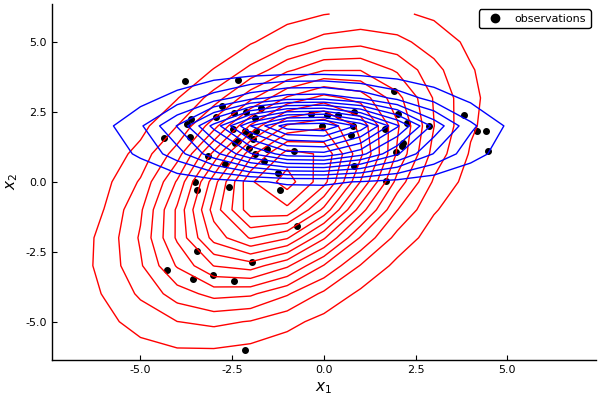

In [10]:
# Extract the means over the MCMC chains
μ1_estimated = mean_chain(chain2, :μ1)
μ2_estimated = mean_chain(chain2, :μ2)
Σ1_estimated = reshape(mean_chain(chain2, :Σ1), (2,2))
Σ2_estimated = reshape(mean_chain(chain2, :Σ2), (2,2))

# Plot data and overlay estimated posterior probabilities
plot_clusters(observations, 
              μ=[μ1_estimated, μ2_estimated], 
              Σ=[Σ1_estimated, Σ2_estimated], 
              x1=range(-7, stop=7), 
              x2=range(-6, stop=6),
              size=(600,400))

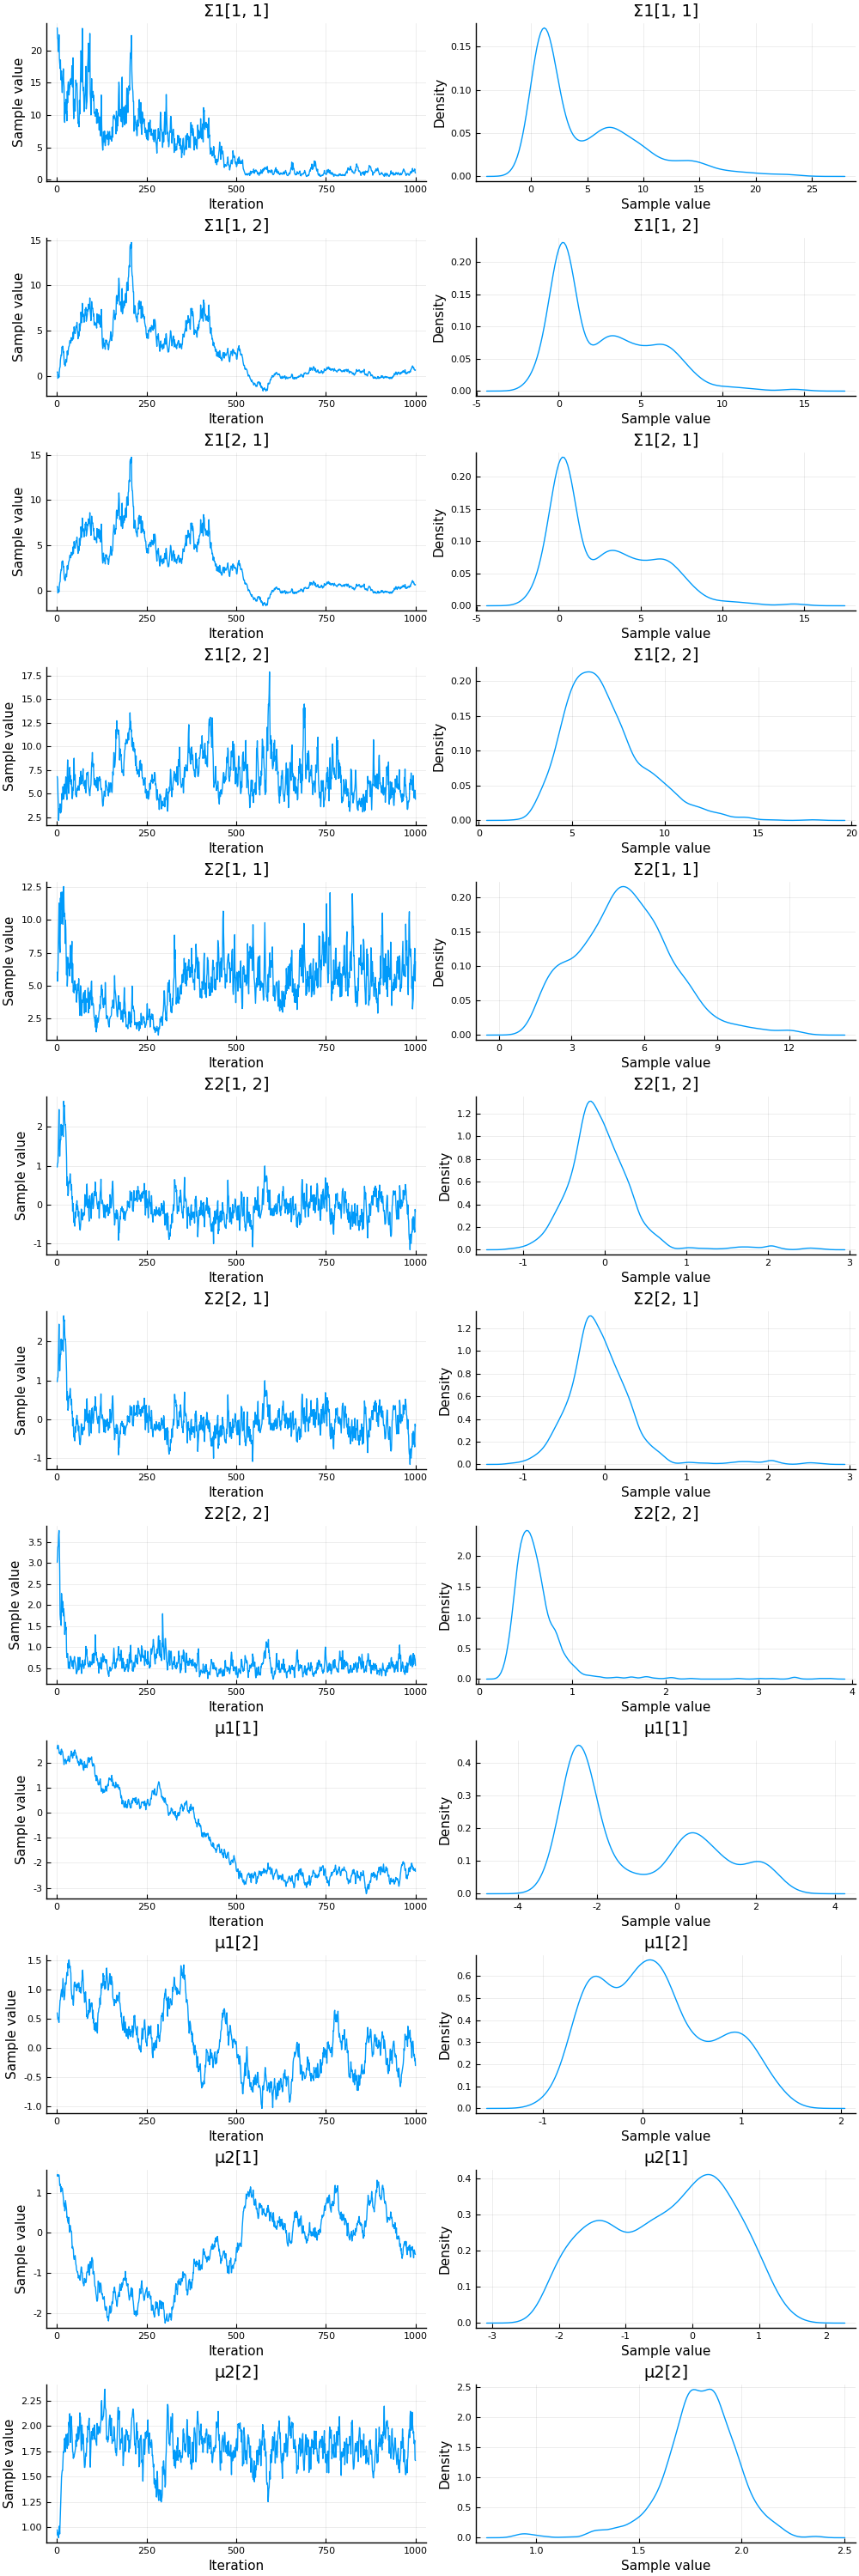

In [11]:
plot(chain2[[:μ1, :Σ1, :μ2, :Σ2]])

### Model 3: means, covariances, mixture weights

In [18]:
@model Gaussian_mixture_model(X, m1, m2, S1, S2, a) = begin
    "2-dimensional Gaussian mixture model with free covariances"
    
    # Data shape
    N, D = size(X)
    
    # Draw a covariance matrix for each cluster
    Σ1 ~ InverseWishart(2, S1)
    Σ2 ~ InverseWishart(2, S2)
    
    # Draw means for each cluster
    μ1 ~ MvNormal(m1, Σ1)
    μ2 ~ MvNormal(m2, Σ2)
    
    # Draw a proportion 
    ϕ ~ Dirichlet(a)
    
    # Concatenate parameters to allow for indexing
    μ = [μ1 μ2]
    Σ = cat(Σ1, Σ2, dims=3)
    
    # Preallocate assignment vector
    z = Vector{Int}(undef, N)
    
    # Loop over observations
    for i in 1:N
        
        # Draw assignment for i-th sample from a Categorical distribution parameterized by ϕ
        z[i] ~ Categorical(ϕ)
        
        # Data point x[i] follows a normal distribution, with mean and covariance indexed by z[i]
        X[i,:] ~ MvNormal(μ[:, z[i]], Σ[:,:, z[i]])
    end
    
    # Return the assignments
    return z
end

# Set prior means
m1 = [-1, -1]
m2 = [+1, +1]

# Set prior covariances
S1 = 2*[1. 0.;0. 1.]
S2 = 2*[1. 0.;0. 1.]

# Set prior proportions
a = [1., 1.]

# Create an instance of a model, using the observations
model3 = Gaussian_mixture_model(observations, m1, m2, S1, S2, a);

We expand the sampler, again contrasting the cluster assignments with the model parameters. 

In [19]:
# Length of the Markov chain
len_chain = 2000

# Construct Gibbs sampler
sampler3 = Gibbs(PG(50, :z), HMC(0.01, 10, :μ1, :μ2, :Σ1, :Σ2, :ϕ))

# Start sampling
chain3 = sample(model3, sampler3, len_chain);

Progress: 100%|█████████████████████████████████████████| Time: 0:15:33


Extract parameters from the chains.

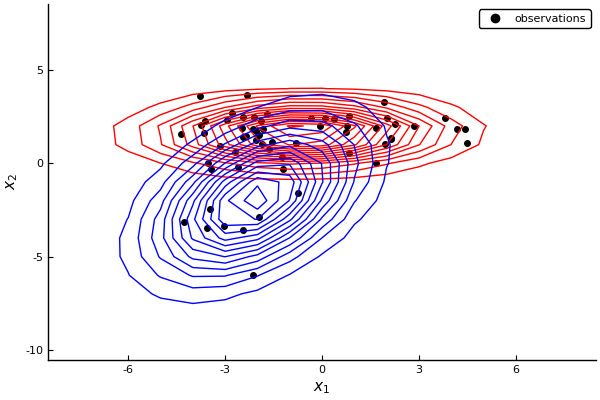

In [20]:
# Extract the means over the MCMC chains
μ1_estimated = mean_chain(chain3, :μ1)
μ2_estimated = mean_chain(chain3, :μ2)
Σ1_estimated = reshape(mean_chain(chain3, :Σ1), (2,2))
Σ2_estimated = reshape(mean_chain(chain3, :Σ2), (2,2))

# Plot data and overlay estimated posterior probabilities
plot_clusters(observations, 
              μ=[μ1_estimated, μ2_estimated], 
              Σ=[Σ1_estimated, Σ2_estimated], 
              x1=range(-8, stop=8), 
              x2=range(-10, stop=8),
              size=(600,400))

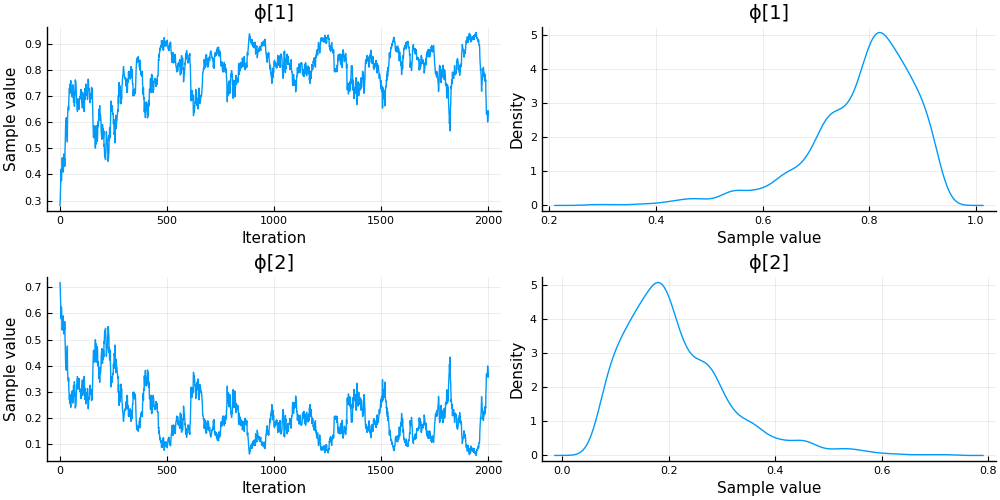

In [21]:
plot(chain3[:ϕ])

### Assignment: 3 clusters

Can you change the model to work with 3 clusters instead of 2?

In [ ]:
### Your code here